# Setup

In [36]:
! pip install transformers newspaper3k

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
The folder you are executing pip from can no longer be found.


In [37]:
# ! python -m spacy download en_core_web_sm

In [38]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [40]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

In [41]:
LABELED_FILE = MAIN_FOLDER + 'activities_labeled.csv'

In [42]:
TARGET = 'label'
TEXT = 'text'
STOPWORDS = set(stopwords.words('english'))

# Working with labeled_activities.csv

In [33]:
columns_used = ['raw_text', 'sanitized_text', 'activity_type']
# columns_used = ['url', 'activity_type']

In [9]:
df2 = pd.read_csv(LABELED_FILE, usecols=columns_used)
df2.rename(columns={columns_used[-1]: TARGET}, inplace=True)

In [29]:
# We make sure that all rows with missing values are the ones that make the 'raw_text' be different from the 'sanitized_text'
assert df2.isna().any(axis=1).sum() == (df2['raw_text'] != df2['sanitized_text']).sum()

In [25]:
df2[df2.isna().any(axis=1)]

,label,raw_text,sanitized_text
3,0,NaN,NaN
20,0,NaN,NaN
54,0,NaN,NaN
88,0,NaN,NaN
123,0,NaN,NaN
...,...,...,...
22327,5,NaN,NaN
22328,5,NaN,NaN
22329,5,NaN,NaN
22330,5,NaN,NaN


In [17]:
df2[df2['raw_text'] != df2['sanitized_text']]

,label,raw_text,sanitized_text
3,0,NaN,NaN
20,0,NaN,NaN
54,0,NaN,NaN
88,0,NaN,NaN
123,0,NaN,NaN
...,...,...,...
22327,5,NaN,NaN
22328,5,NaN,NaN
22329,5,NaN,NaN
22330,5,NaN,NaN


In [140]:
# columns_used = ['raw_text', 'sanitized_text', 'activity_type']
columns_used = ['url', 'activity_type']

In [141]:
df2 = pd.read_csv(LABELED_FILE, usecols=columns_used)
df2.rename(columns={columns_used[-1]: TARGET}, inplace=True)
df2 = df2[[columns_used[0], TARGET]]
df2[TARGET].replace({0: 'event', 1: 'webinar', 2: 'press release', 3: 'blog', 4: 'twitter', 5: 'linkedin'}, inplace=True)

In [142]:
df2.sample(5)

,url,label
13762,http://twitter.com/ShipTime/status/13866904371...,twitter
6335,http://twitter.com/Secureship/status/140522383...,twitter
21699,https://www.linkedin.com/search/results/conten...,linkedin
8514,http://twitter.com/ShipStation/status/13956808...,twitter
618,http://www.shipengine.com/meet-shipengine-at-r...,blog


In [143]:
df2.shape

(23177, 2)

In [144]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23177 entries, 0 to 23176
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     23177 non-null  object
 1   label   23177 non-null  object
dtypes: object(2)
memory usage: 362.3+ KB


In [145]:
df2[TARGET].value_counts()

twitter          13726
linkedin          3735
blog              3733
press release     1287
event              368
webinar            328
Name: label, dtype: int64

In [146]:
df2.isna().sum(axis=0)

url      0
label    0
dtype: int64

In [166]:
LINKEDIN_URL = 'linkedin.com/search'
TWITTER_URL = 'twitter.com'
BLOG_URL = '/blog/'

In [148]:
df2[df2[TARGET] == 'twitter']

,url,label
4101,http://twitter.com/Shopify/status/152736361974...,twitter
4102,http://twitter.com/3PLCentral/status/150633130...,twitter
4103,http://twitter.com/Secureship/status/157300936...,twitter
4104,http://twitter.com/Secureship/status/157303194...,twitter
4105,http://twitter.com/Secureship/status/157162769...,twitter
...,...,...
19165,http://twitter.com/charteralliance/status/1364...,twitter
19180,http://twitter.com/ShipBob/status/141027462848...,twitter
19319,http://twitter.com/ShipBob/status/140241475602...,twitter
19329,http://twitter.com/ZohoInventory/status/139579...,twitter


In [149]:
df2

,url,label
0,http://app.livestorm.co/shippo/live-demo-shipp...,event
1,http://info.shiphawk.com/acumatica-summit-2021,event
2,http://www.wmxamericas.com/,event
3,http://app.livestorm.co/shippo/peak-season-shi...,event
4,http://www.thedeliveryconference.com/,event
...,...,...
23172,https://www.linkedin.com/search/results/conten...,linkedin
23173,https://www.linkedin.com/search/results/conten...,linkedin
23174,https://www.linkedin.com/search/results/conten...,linkedin
23175,https://www.linkedin.com/search/results/conten...,linkedin


In [150]:
df2[TARGET].value_counts()

twitter          13726
linkedin          3735
blog              3733
press release     1287
event              368
webinar            328
Name: label, dtype: int64

In [151]:
df2[df2['url'].str.contains(LINKEDIN_URL)]

,url,label
19442,https://www.linkedin.com/search/results/conten...,linkedin
19443,https://www.linkedin.com/search/results/conten...,linkedin
19444,https://www.linkedin.com/search/results/conten...,linkedin
19445,https://www.linkedin.com/search/results/conten...,linkedin
19446,https://www.linkedin.com/search/results/conten...,linkedin
...,...,...
23172,https://www.linkedin.com/search/results/conten...,linkedin
23173,https://www.linkedin.com/search/results/conten...,linkedin
23174,https://www.linkedin.com/search/results/conten...,linkedin
23175,https://www.linkedin.com/search/results/conten...,linkedin


Working with LinkedIn labels:

In [152]:
# Make sure that all rows whose urls contain LINKEDIN_URL have their label == 'linkedin'
assert (df2[df2['url'].str.contains(LINKEDIN_URL)][TARGET] == 'linkedin').all()

In [153]:
# Make sure that all rows whose urls don't contain LINKEDIN_URL have their label != 'linkedin'
assert (df2[~df2['url'].str.contains(LINKEDIN_URL)][TARGET] != 'linkedin').all()

In [154]:
# Make sure that the sum of all rows whose urls contain and don't contain LINKEDIN_URL are the total rows of the dataframe
assert df2.shape[0] == (df2[df2['url'].str.contains(LINKEDIN_URL)][TARGET] == 'linkedin').shape[0] + (df2[~df2['url'].str.contains(LINKEDIN_URL)][TARGET] != 'linkedin').shape[0]

Working with Twitter labels:

In [160]:
# Make sure that all rows whose urls contain LINKEDIN_URL have their label == 'twitter'
assert (df2[df2['url'].str.contains(TWITTER_URL)][TARGET] == 'twitter').all()

In [158]:
# Make sure that all rows whose urls don't contain TWITTER_URL have their label != 'twitter'
assert (df2[~df2['url'].str.contains(TWITTER_URL)][TARGET] != 'twitter').all()

In [159]:
# # Make sure that the sum of all rows whose urls contain and don't contain LINKEDIN_URL are the total rows of the dataframe
assert df2.shape[0] == (df2[df2['url'].str.contains(LINKEDIN_URL)][TARGET] == 'linkedin').shape[0] + (df2[~df2['url'].str.contains(LINKEDIN_URL)][TARGET] != 'linkedin').shape[0]

Working with Blog labels:

In [167]:
# Make sure that all rows whose urls contain LINKEDIN_URL have their label == 'twitter'
assert (df2[df2['url'].str.contains(BLOG_URL)][TARGET] == 'blog').all()

AssertionError: ignored

In [169]:
df2[df2['url'].str.contains(BLOG_URL)].tail(10)

,url,label
4099,http://www.shopify.com/blog/givemetap-social-i...,blog
4100,http://www.3plcentral.com/blog/how-continuous-...,blog
18470,http://picante.today/blog/2022/04/12/shopify-a...,press release
18498,http://picante.today/blog/2022/04/11/shopify-a...,press release
18632,http://www.exchangewire.com/blog/2021/03/12/im...,press release
18918,http://www.retailgazette.co.uk/blog/2022/06/sh...,press release
18987,http://picante.today/blog/2022/07/27/shopify-r...,press release
19151,http://www.webinterpret.com/us/blog/free-webin...,webinar
19321,http://www.pitneybowes.com/us/blog/latest-supp...,webinar
19332,http://www.shipbob.com/blog/3pl-or-invest-ware...,webinar


In [170]:
df2[TARGET].value_counts()

twitter          13726
linkedin          3735
blog              3733
press release     1287
event              368
webinar            328
Name: label, dtype: int64

In [172]:
df2[df2[TARGET] == 'webinar']['url']

19109    http://appficiencyinc.zoom.us/webinar/register...
19110    http://web.archive.org/web/20210224233830/http...
19111    http://event.on24.com/eventRegistration/EventL...
19112    http://primecampagneadvperlecommerce.splashtha...
19113    http://cbre.zoom.us/webinar/register/WN_0eGKQy...
                               ...                        
19437    http://web.cvent.com/event/4709a75a-6ab8-4d67-...
19438    http://app.livestorm.co/katana/prepare-your-bu...
19439    http://newyork.shopify.com/rewritingthebookons...
19440    http://www.meetup.com/austin-homegrown-api/eve...
19441    http://info.shiphawk.com/webinars?hss_channel=...
Name: url, Length: 328, dtype: object

Working with the other 4 labels:

In [161]:
df_four = df2[~df2[TARGET].isin(['twitter', 'linkedin'])]

In [162]:
df_four[TARGET].value_counts()

blog             3733
press release    1287
event             368
webinar           328
Name: label, dtype: int64

In [96]:
df_four[df_four[TARGET] == 'blog']

,url,label
368,http://www.shopify.com/blog/aapi-heritage-mont...,blog
369,http://www.shopify.com/blog/how-to-use-instagr...,blog
370,http://www.shopify.com/blog/15-facebook-ad-tar...,blog
371,http://www.shopify.com/blog/customer-engagement,blog
372,http://www.shopify.com/blog/blog-pans-mushroom...,blog
...,...,...
4096,http://shiphero.com/blog/5-keys-to-determining...,blog
4097,http://www.3plcentral.com/blog/risks-your-3pl-...,blog
4098,http://www.shipmonk.com/blog/peak-season-2022-...,blog
4099,http://www.shopify.com/blog/givemetap-social-i...,blog


In [165]:
df_four[df_four[TARGET] == 'blog']['url'].str.contains('/blog/') 
# is data reliable? all rows labeled as 'blog' contain the string 'blog' in their url, is this because that's the way data was labeled before?
# because if i get a blog whose url doesn't contain the word 'blog' in it, it is going to be misclassified

368     True
369     True
370     True
371     True
372     True
        ... 
4096    True
4097    True
4098    True
4099    True
4100    True
Name: url, Length: 3733, dtype: bool

In [46]:
url = df2.loc[0, 'url']

toi_article = Article(url = url, language = "en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

toi_article.text

"About this event\n\nShippo Automation Rules\n\nWe're excited to announce our latest time-saving feature, automating package and carrier selections with Shippo's Automation Rules!\n\nJoin our LIVE event where we'll cover the basics of automation and demonstrate how to set up effective rules. Seats are filling out fast, so make sure to register and reserve your spot now!\n\nWe'll show you how to automatically assign packages and carrier services to orders based on parameters you specify — like the order's quantity, weight, or specific items within the order. Once you create your automation rules, all new orders imported into Shippo will be automatically adjusted according to the preferences you set.\n\nWe hope to see you there!"

In [47]:
url = df2.loc[3, 'url']

toi_article = Article(url = url, language = "en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

toi_article.text

'About this event\n\nPeak season is upon us, which means you’ve likely been gearing up your fulfillment operations to meet the growing consumer demand. As you prepare to face the logistical issues that can come with that spike, there are likely plenty of questions about how to best tackle challenges and delight your customers during this busy time of year.\n\nJoin resident shipping experts Amanda Jaramillo, Blake Bryant, and LeKea DeBose to learn:\n\nPractical tips for surviving the peak season shipping and returns rush\n\nReal-life examples of how e-commerce retailers are preparing for peak this year\n\nWhich innovative solutions can help you get and stay ahead of the shipping crunch\n\nQuestions? Need help? Sign into your Shippo account to chat with support.'

In [49]:
url = 'https://twitter.com/Secureship/status/1482110423029755908'

toi_article = Article(url = url, language = "en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

toi_article.text

'JavaScript is not available.\n\nWe’ve detected that JavaScript is disabled in this browser. Please enable JavaScript or switch to a supported browser to continue using twitter.com. You can see a list of supported browsers in our Help Center.\n\nHelp Center'

# Defining functions get_data and preprocessing:

In [43]:
def get_html_files(html_folder=HTML_FOLDER):
  html_files = os.listdir(html_folder)
  return html_files

In [44]:
def create_df(csv_path, usecols):
  df = pd.read_csv(csv_path, usecols = usecols)
  df.rename(columns={usecols[0]: 'filename', usecols[1]: 'label'}, inplace=True)
  df = df[~df['filename'].isna()]
  print(f'Original shape: {df.shape}')
  df = df[df['label'] != '-']
  df.reset_index(drop=True, inplace=True)
  print(f'Final shape: {df.shape}')
  return df

In [45]:
def get_target_distribution(df, normalize=False):
  return df[TARGET].value_counts(normalize=normalize)

In [46]:
def read_htmls(filenames):
  htmls = list()

  for i, filename in enumerate(filenames):
    try:
      with open(f'{HTML_FOLDER}{filename}') as f:
        html = f.read()
        htmls.append(html)
    except FileNotFoundError:
      print(f'File {i} not found: "{filename}"')
  
  return htmls

In [47]:
def read_articles(htmls):
  toi_articles = list()

  for html in htmls:
    toi_article = Article(url = ' ', language = "en")
    toi_article.set_html(html)
    toi_article.parse()
    toi_article.nlp()
    toi_articles.append(toi_article)

  # toi_articles = (Article(url = ' ', language = "en").set_html(html).parse().nlp() for html in tqdm(htmls, total=len([htmls])))
  # toi_articles = (Article(url = ' ', language = "en").set_html(html).parse().nlp() for html in tqdm(htmls))

  return toi_articles

In [48]:
def create_y(df):
  return df[TARGET].tolist()

In [49]:
def create_summary(toi_articles):
  title_and_summary = [(toi_article.title + '. ' + toi_article.summary).replace('\n', ' ') for toi_article in toi_articles]
  # title_and_summary = ((toi_article.title + '. ' + toi_article.summary).replace('\n', ' ') for toi_article in tqdm(toi_articles, total=len([toi_articles])))
  # title_and_summary = ((toi_article.title + '. ' + toi_article.summary).replace('\n', ' ') for toi_article in tqdm(toi_articles))
  return title_and_summary

In [50]:
def create_df_text(title_and_summary, y, minimum_words, maximum_classes):
  df_text = pd.DataFrame({TEXT: title_and_summary, TARGET: y})
  # df_text[TEXT] = df_text.loc[:, TEXT].str.lower()

  if minimum_words:
    df_text = df_text[df_text[TEXT].str.split().str.len() > minimum_words]

  if maximum_classes:
    relevant_labels = df_text[TARGET].value_counts()[:maximum_classes].index
    df_text = df_text[df_text[TARGET].isin(relevant_labels)]
    
  df_text.reset_index(drop=True, inplace=True)

  return df_text

In [51]:
def split_X_y(df, test_size, random_state):
  X = df.drop(TARGET, axis=1)
  y = df[TARGET]

  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=test_size,
                                                      stratify=y, 
                                                      random_state=random_state)
  return X_train, X_test, y_train, y_test

In [52]:
def get_baseline_accuracy(y_train, y_test):
  majority_class = y_train.value_counts().index[0]
  baseline_accuracy = sum(y_test == majority_class) / len(y_test)
  return baseline_accuracy

In [53]:
def get_most_common_tokens(X_train, amount=10):
  tokenized = [word_tokenize(string) for string in X_train[TEXT]]
  flat_list = [item for sublist in tokenized for item in sublist]
  return Counter(flat_list).most_common(amount)

In [54]:
def load_nlp():
  nlp = spacy.load('en_core_web_sm')
  return nlp

In [55]:
def lemmatize_text(X_train, nlp):
  lemmatized_text = list()
  for text in X_train[TEXT]:
    lemmas = [token.lemma_.lower() for token in nlp(text)]
    lemmatized_text.append(lemmas)

  return lemmatized_text

In [56]:
def fit_transform_articles(X_train, X_test, vectorizer, stop_words):
  vectorizers = {'count': CountVectorizer(stop_words=stop_words), 'tfidf': TfidfVectorizer(stop_words=stop_words)}

  try:
    vectorizer = vectorizers[vectorizer]
  except KeyError:
    raise KeyError("vectorizer should be either 'count' or 'tfidf'")

  X_train_transformed = vectorizer.fit_transform(X_train[TEXT])
  X_test_transformed = vectorizer.transform(X_test[TEXT])

  return X_train_transformed, X_test_transformed, vectorizer

In [85]:
def get_data(csv_path='url_classification_temporary.csv', usecols=['File Name', 'Label']):
  df = create_df(csv_path, usecols)
  y = create_y(df)

  # get_target_distribution(df, normalize=True)

  html_raw_labeled = read_htmls(df['filename'].values)
  toi_articles_labeled = read_articles(html_raw_labeled)
  assert len(toi_articles_labeled) == len(y)
  title_and_summary_labeled = create_summary(toi_articles_labeled)

# Do the following lines to perform 'TF-IDF' using all html files:
  # html_filenames = get_html_files()
  # html_raw_total = read_htmls(html_filenames)
  # toi_articles_total = read_articles(html_raw_total)
  # title_and_summary_total = create_summary(toi_articles_total)

  return df, y, title_and_summary_labeled
  # return df, y, title_and_summary_labeled, title_and_summary_total


def preprocessing(y, title_and_summary_labeled, maximum_classes=4, minimum_words=30, test_size=0.2, random_state=None, vectorizer='count', stop_words=None):
  df_text = create_df_text(title_and_summary_labeled, y, minimum_words, maximum_classes)
  X_train, X_test, y_train, y_test = split_X_y(df_text, test_size, random_state)
  # get_baseline_accuracy(y_train, y_test)
  # get_most_common_tokens(amount=5)
  nlp = load_nlp() # NOT USING IT, NECESSARY? DON'T THINK SO, BUT CHECK
  # lemmatized_text = lemmatize_text(X_train, nlp) # NOT USING IT, NECESSARY? DON'T THINK SO, BUT CHECK
  X_train_transformed, X_test_transformed, vectorizer = fit_transform_articles(X_train, X_test, vectorizer, stop_words) # to see output: X_train.toarray() or X_test.toarray()


  return X_train_transformed, X_test_transformed, y_train, y_test, vectorizer

# Defining functions for modeling:

In [58]:
def fit_model(clf, X_train_transformed, y_train):
  clf.fit(X_train_transformed, y_train)
  return clf

In [59]:
def predict(clf, X_test_transformed):
  y_pred = clf.predict(X_test_transformed)
  return y_pred

In [60]:
def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy

In [61]:
def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{clf.classes_[i]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')

In [62]:
def print_confusion_matrix(y_test, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion matrix - acc {get_accuracy(y_test, y_pred):.3f}', size=15)
  plt.show()

# Executing functions get_data and preprocessing:

In [63]:
df, y, title_and_summary_labeled = get_data(csv_path='url_classification_temporary7.csv')

Original shape: (373, 2)
Final shape: (310, 2)


In [ ]:
# For future use:

# vectorizer = TfidfVectorizer().fit(...)
# X_train_transformed = vectorizer.transform(X_train[TEXT])
# X_test_transformed = vectorizer.transform(X_test[TEXT])

In [64]:
df_text = create_df_text(title_and_summary_labeled, y, minimum_words=30, maximum_classes=4)

In [65]:
df_text

,text,label
0,Write For Us. We allow you an endless opportun...,MISC
1,Write for Us. If you’ve got an idea that will ...,MISC
2,FAQs for some new features available in the Be...,Blog
3,The Web Credibility Project. Our research in W...,Home Page
4,Model DJs for Retail. DJPeoples is the nation’...,MISC
...,...,...
223,"COVID-Safe Policy, Procedures and Guidelines. ...",MISC
224,Scary (But True) Small Business Statistics You...,Blog
225,50 Ways To Improve On-Page SEO [Infographic]. ...,Blog
226,Digital Marketers Organization. ★★★★★The DMO t...,Home Page


In [66]:
print(f"Amount of words before cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")

Amount of words before cleaning text: 22764


In [67]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text

    # nlp = load_nlp()
    # text = ' '.join(token.lemma_ for token in nlp(text))

    return text

In [68]:
df_text[TEXT] = df_text[TEXT].apply(clean_text)

In [69]:
df_text

,text,label
0,write us allow endless opportunity new authors...,MISC
1,write us youve got idea challenge readers move...,MISC
2,faqs new features available beta wayback machi...,Blog
3,web credibility project research web credibili...,Home Page
4,model djs retail djpeoples nations premier age...,MISC
...,...,...
223,covidsafe policy procedures guidelines digimar...,MISC
224,scary true small business statistics cant affo...,Blog
225,50 ways improve onpage seo infographic onpage ...,Blog
226,digital marketers organization dmo team amazin...,Home Page


In [70]:
print(f"Amount of words after cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")

Amount of words after cleaning text: 14026


In [71]:
X_train, X_test, y_train, y_test = split_X_y(df_text, test_size=0.2, random_state=0)
# get_baseline_accuracy(y_train, y_test)
# get_most_common_tokens(amount=5)
# nlp = load_nlp() # NOT USING IT, NECESSARY? DON'T THINK SO, BUT CHECK
# lemmatized_text = lemmatize_text(X_train, nlp) # NOT USING IT, NECESSARY? DON'T THINK SO, BUT CHECK

In [72]:
X_train_transformed, X_test_transformed, vectorizer = fit_transform_articles(X_train, X_test, vectorizer='tfidf', stop_words=None)

In [73]:
X_train_transformed.shape, X_test_transformed.shape, y_train.shape, y_test.shape

((182, 3539), (46, 3539), (182,), (46,))

In [74]:
X_train

,text
0,write us allow endless opportunity new authors...
134,stand online 45 experts share top tips big que...
139,blush brow company welcome home things aesthet...
222,digital marketing media advertising conference...
21,4t medical customers sayi using products 4t me...
...,...
160,magento adobe commerce commerce completely sca...
100,persuasive essay ultimate guide writing persua...
155,using links named anchors improve search resul...
177,improved sale badges woocommerce improved badg...


In [75]:
X_train_transformed.toarray()[0].max()

0.6530878757489279

# EDA

# Executing functions for modeling:

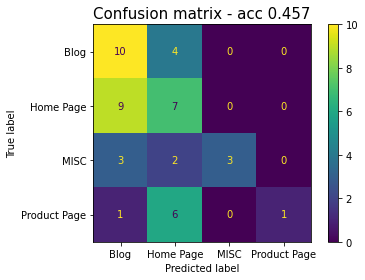

In [76]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                   random_state=0), 
                X_train_transformed, 
                y_train)

y_pred = predict(clf, X_test_transformed)

# print_important_features(clf, features=5)

print_confusion_matrix(y_test, y_pred)

In [107]:
# print_confusion_matrix(y_test, y_pred) # 3rd version

In [108]:
# print_confusion_matrix(y_test, y_pred) # 4th version

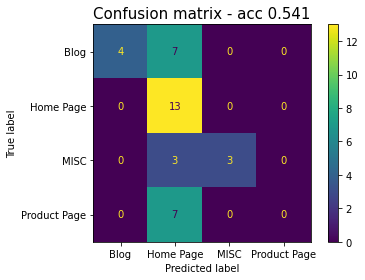

In [109]:
print_confusion_matrix(y_test, y_pred) # 5th version

#### Trying SVM

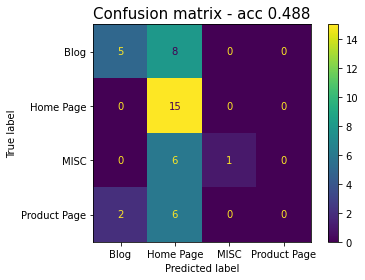

In [129]:
clf = fit_model(SVC(C=1.0,
                    class_weight='balanced', 
                    random_state=0), 
                X_train_transformed, 
                y_train)

y_pred = predict(clf, X_test_transformed)

print_confusion_matrix(y_test, y_pred) # 4th version

#### Trying KNN 5

In [36]:
# # without stop words
# clf = fit_model(KNeighborsClassifier(n_neighbors=5), 
#                 X_train_transformed, 
#                 y_train)

# y_pred = predict(clf, X_test_transformed)

# print_confusion_matrix(y_test, y_pred)

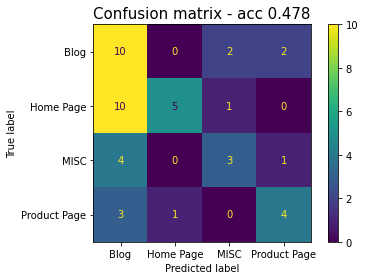

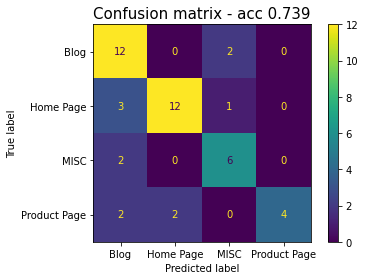

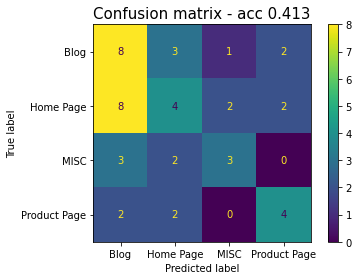

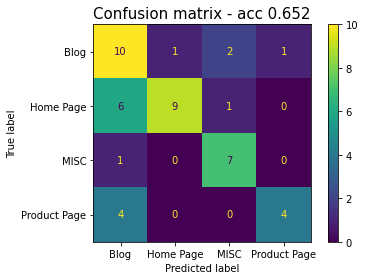

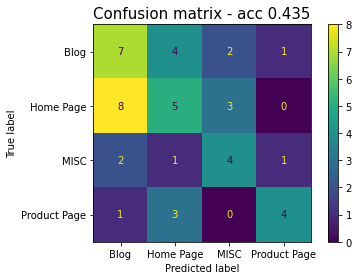

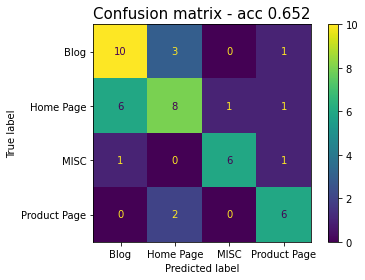

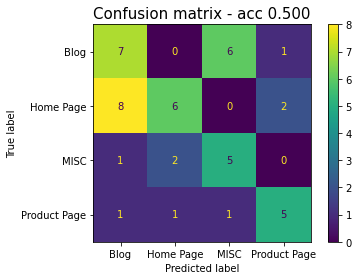

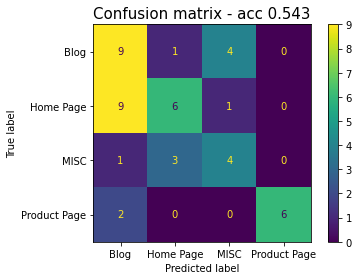

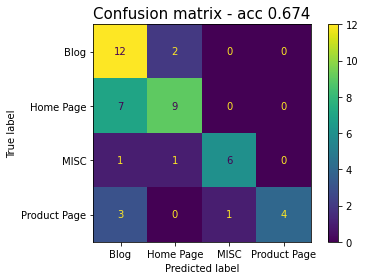

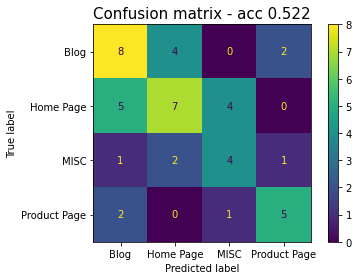

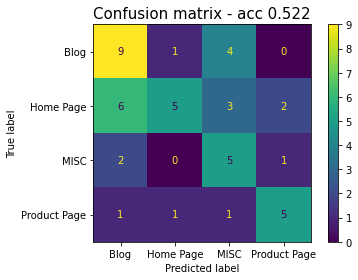

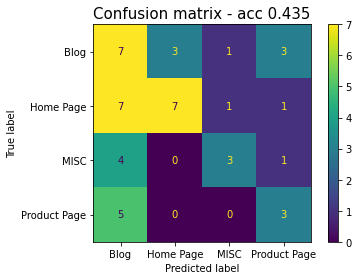

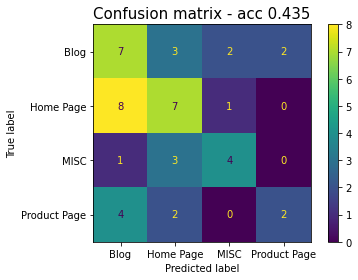

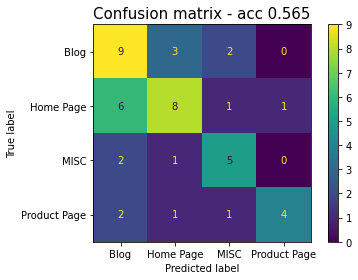

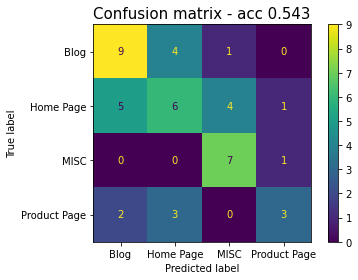

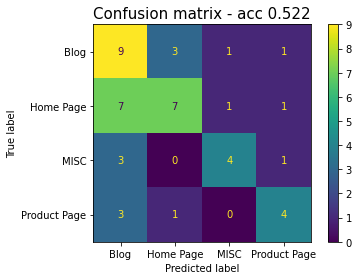

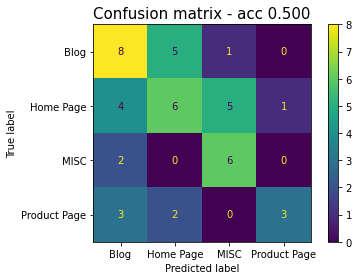

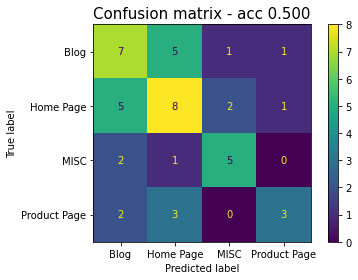

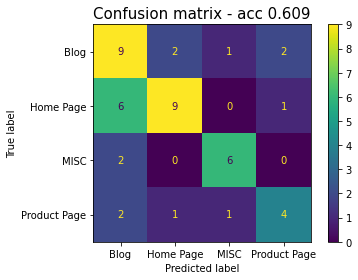

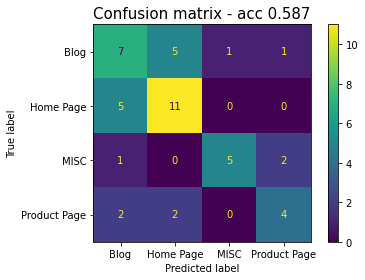

In [86]:
# with stop words from NLTK
# playing with different random states:
for i in range(20):
  X_train_transformed, X_test_transformed, y_train, y_test, vectorizer = preprocessing(y, title_and_summary_labeled, maximum_classes=4, 
                                                                                      test_size=0.2, random_state=i, vectorizer='tfidf', stop_words=STOPWORDS)

  clf = fit_model(KNeighborsClassifier(n_neighbors=5), 
                  X_train_transformed, 
                  y_train)

  y_pred = predict(clf, X_test_transformed)

  print_confusion_matrix(y_test, y_pred)

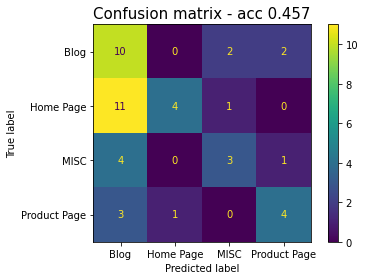

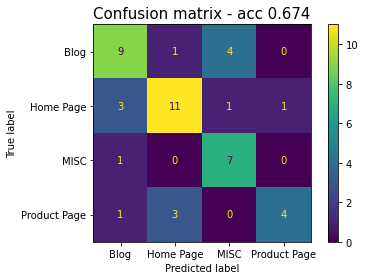

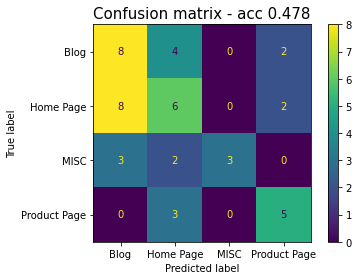

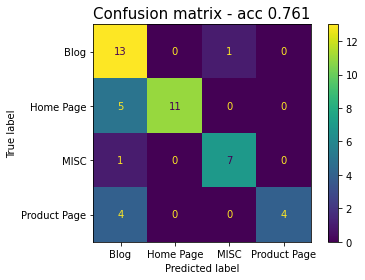

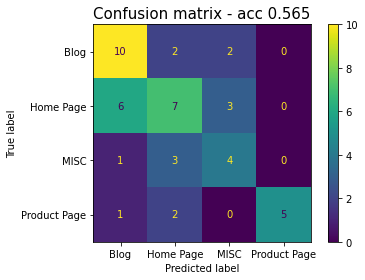

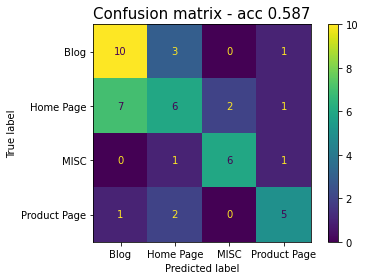

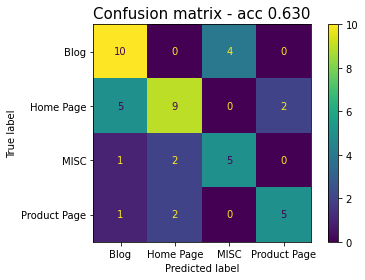

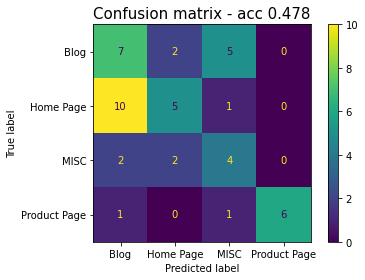

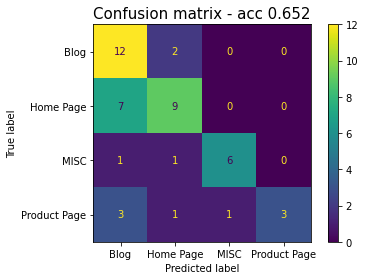

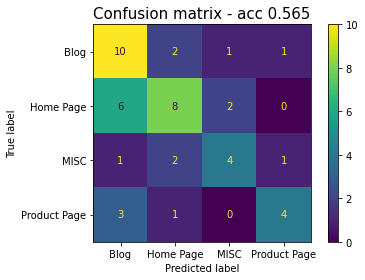

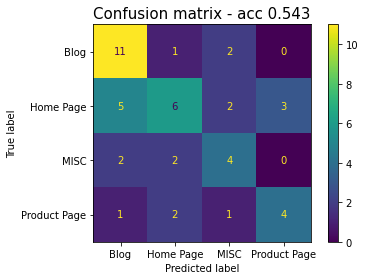

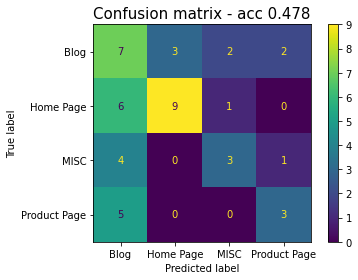

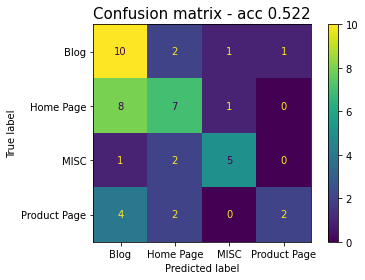

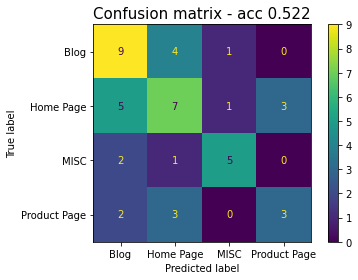

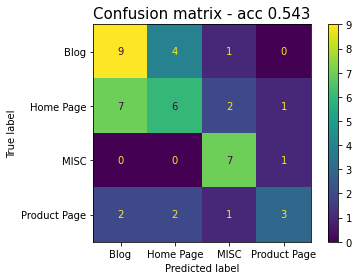

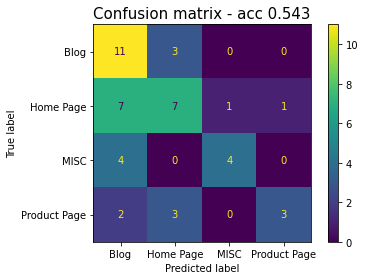

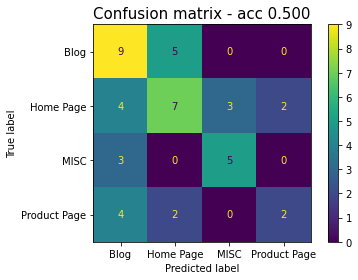

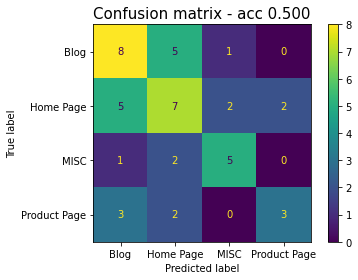

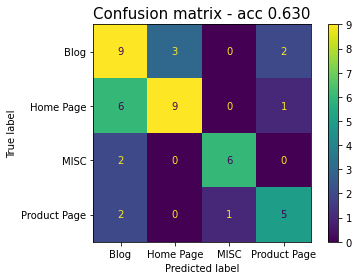

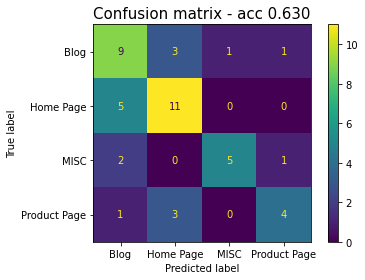

In [88]:
# with stop words from NLTK
# playing with different random states:
for i in range(20):
  X_train_transformed, X_test_transformed, y_train, y_test, vectorizer = preprocessing(y, title_and_summary_labeled, maximum_classes=4, 
                                                                                      test_size=0.2, random_state=i, vectorizer='tfidf', stop_words=STOPWORDS)

  clf = fit_model(KNeighborsClassifier(n_neighbors=6), 
                  X_train_transformed, 
                  y_train)

  y_pred = predict(clf, X_test_transformed)

  print_confusion_matrix(y_test, y_pred)

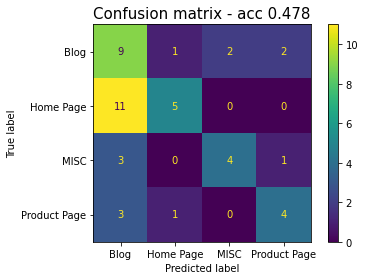

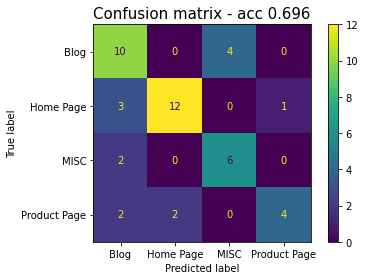

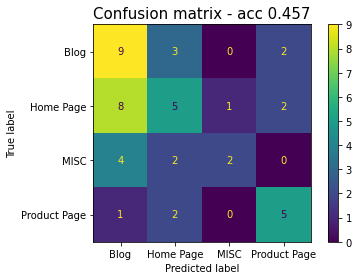

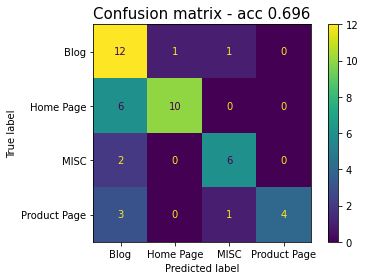

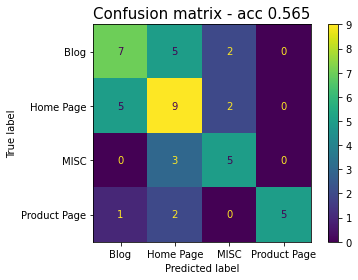

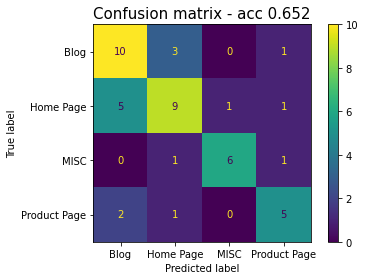

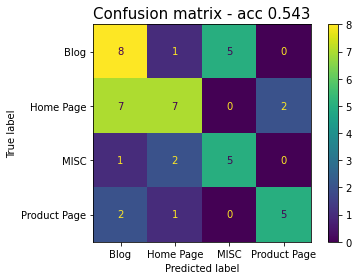

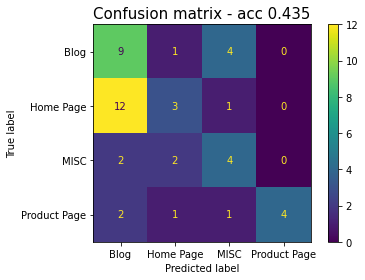

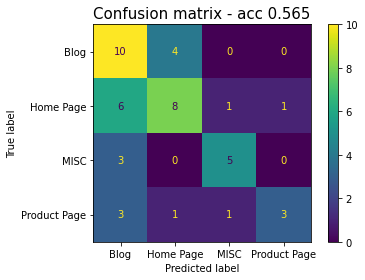

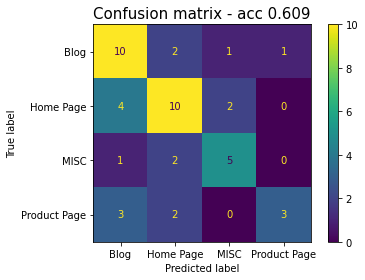

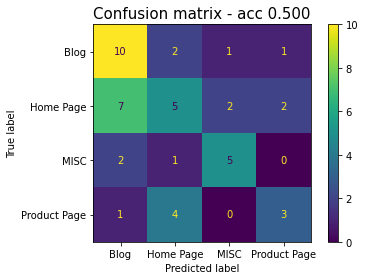

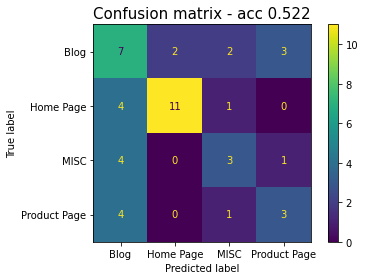

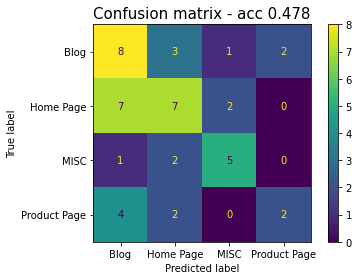

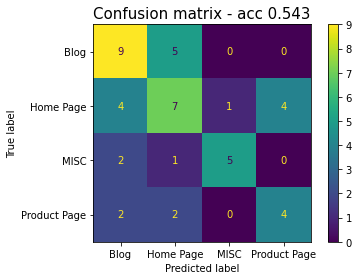

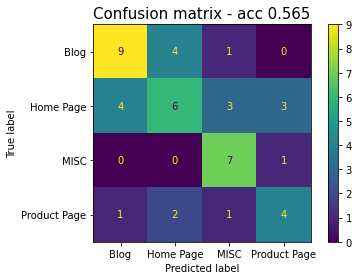

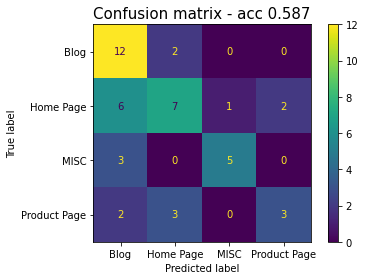

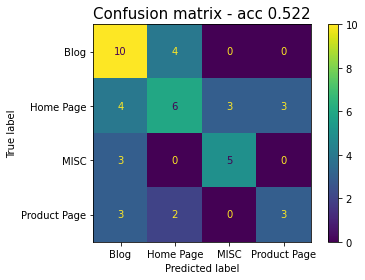

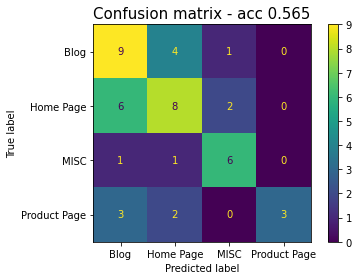

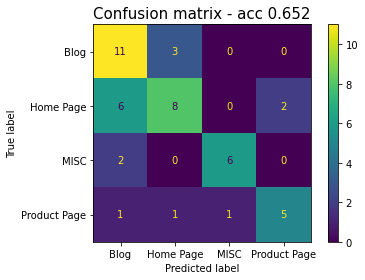

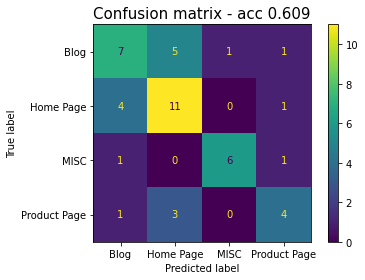

In [91]:
# with stop words from NLTK
# playing with different random states:
for i in range(20):
  X_train_transformed, X_test_transformed, y_train, y_test, vectorizer = preprocessing(y, title_and_summary_labeled, maximum_classes=4, 
                                                                                      test_size=0.2, random_state=i, vectorizer='tfidf', stop_words=STOPWORDS)

  clf = fit_model(KNeighborsClassifier(n_neighbors=7), 
                  X_train_transformed, 
                  y_train)

  y_pred = predict(clf, X_test_transformed)

  print_confusion_matrix(y_test, y_pred)

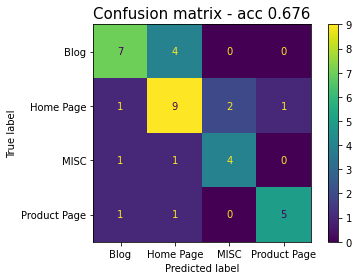

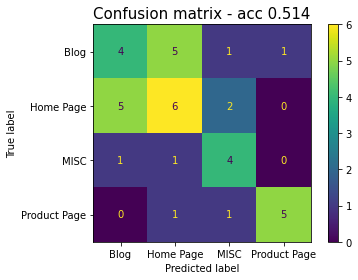

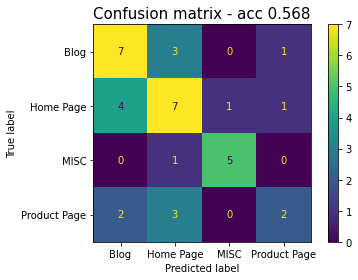

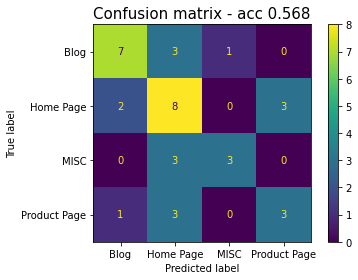

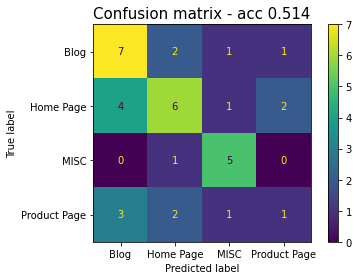

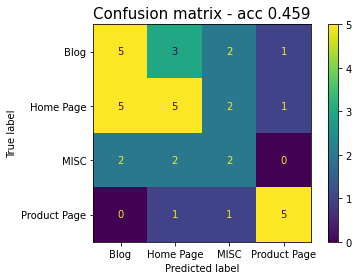

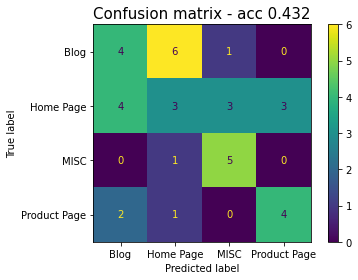

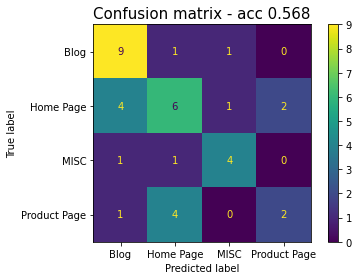

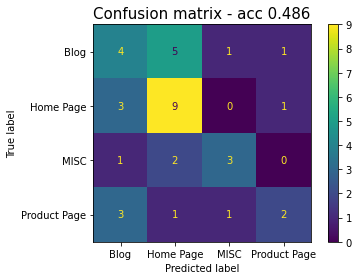

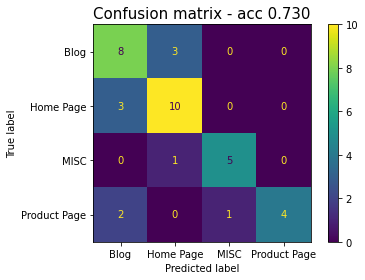

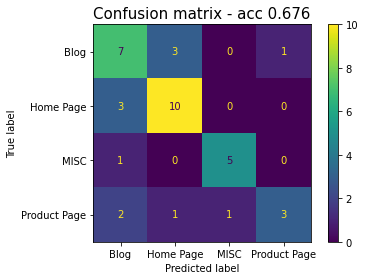

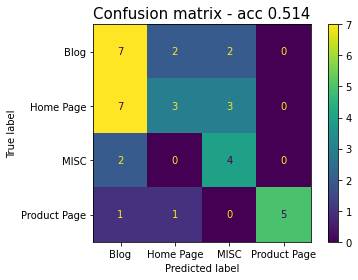

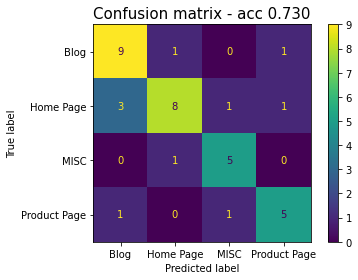

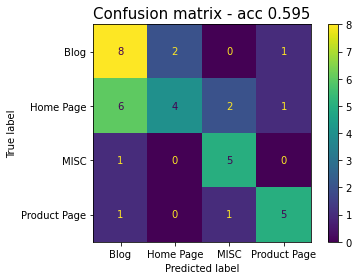

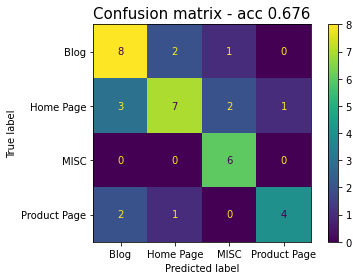

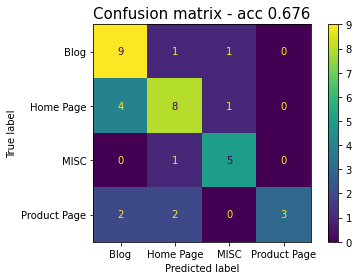

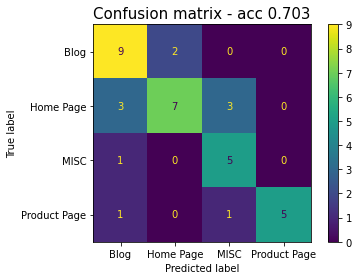

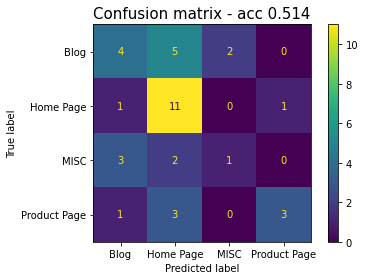

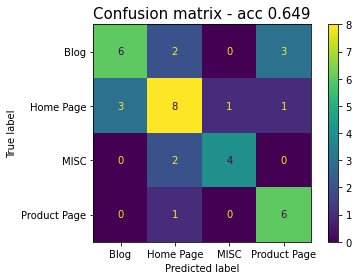

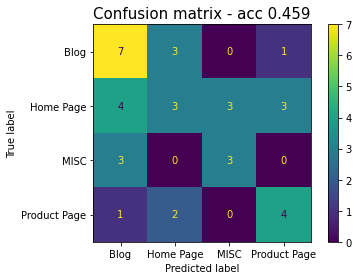

In [112]:
# with stop words from NLTK
# playing with different random states:
for i in range(20):
  X_train_transformed, X_test_transformed, y_train, y_test, vectorizer = preprocessing(y, title_and_summary, maximum_classes=4, 
                                                                                      test_size=0.2, random_state=i, vectorizer='tfidf', stop_words=STOPWORDS)

  clf = fit_model(KNeighborsClassifier(n_neighbors=6), 
                  X_train_transformed, 
                  y_train)

  y_pred = predict(clf, X_test_transformed)

  print_confusion_matrix(y_test, y_pred)

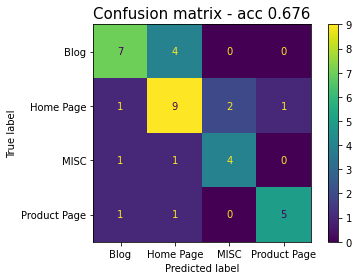

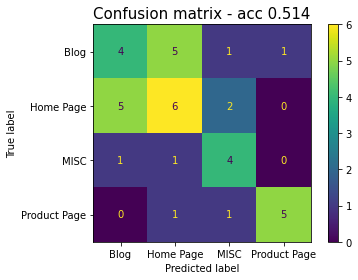

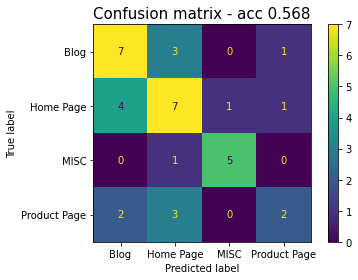

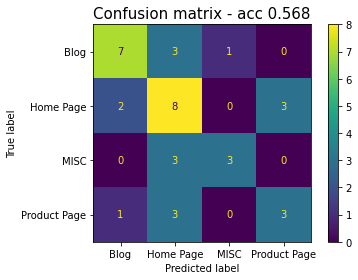

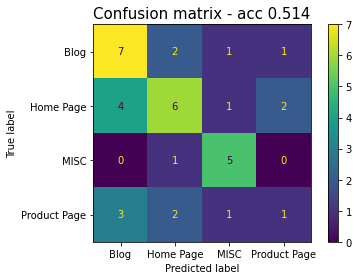

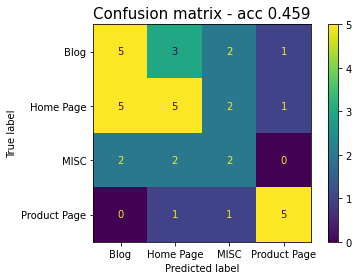

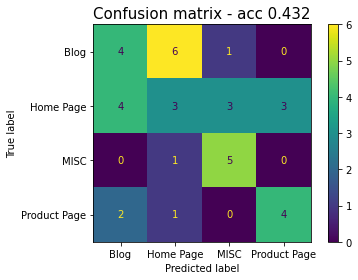

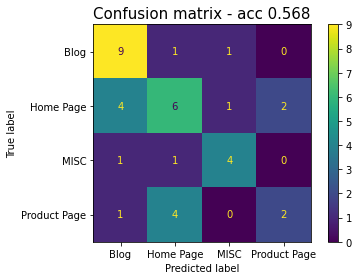

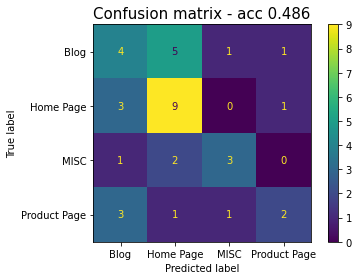

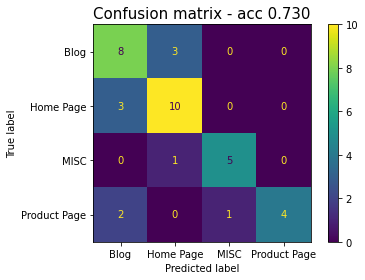

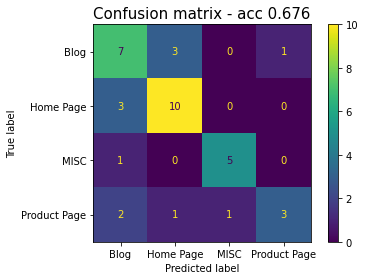

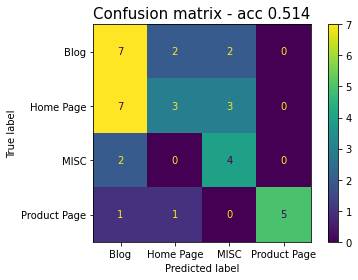

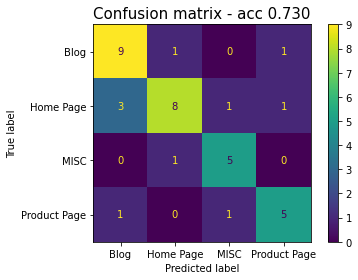

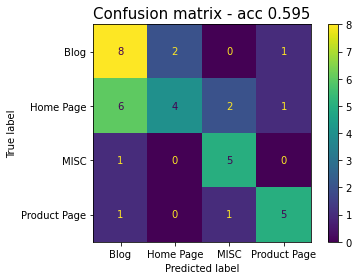

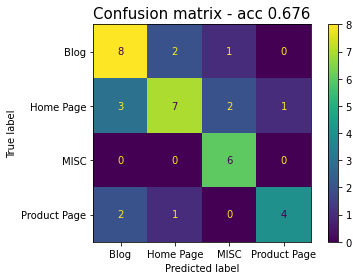

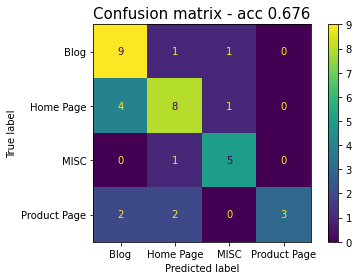

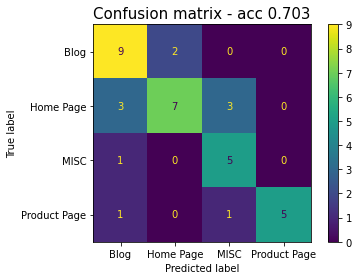

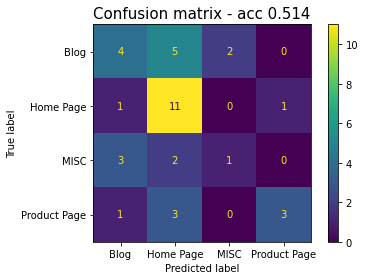

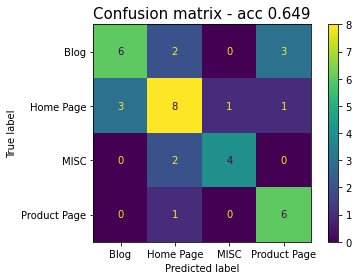

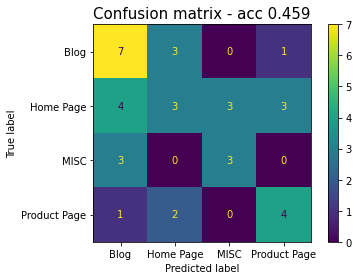

In [43]:
# with stop words from NLTK
# playing with different random states:
for i in range(20):
  X_train_transformed, X_test_transformed, y_train, y_test, vectorizer = preprocessing(y, title_and_summary, maximum_classes=4, 
                                                                                      test_size=0.2, random_state=i, vectorizer='tfidf', stop_words=STOPWORDS)

  clf = fit_model(KNeighborsClassifier(n_neighbors=6), 
                  X_train_transformed, 
                  y_train)

  y_pred = predict(clf, X_test_transformed)

  print_confusion_matrix(y_test, y_pred)

### Continuation

In [ ]:
t

In [ ]:
# # until row 281
# clf = fit_model(model=SVC(C=1,
#                           class_weight='balanced', 
#                           random_state=0), 
#                 X_train=X_train_transformed, 
#                 y_train=y_train)

# y_pred = predict(clf, X_test=X_test_transformed)

# get_accuracy(y_test, y_pred)

In [ ]:
# # until row 295
# clf = fit_model(model=SVC(C=1,
#                           class_weight='balanced', 
#                           random_state=0), 
#                 X_train=X_train_transformed, 
#                 y_train=y_train)

# y_pred = predict(clf, X_test=X_test_transformed)

# get_accuracy(y_test, y_pred)

In [77]:
def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy

In [84]:
# until row 295
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=4000,
                                              random_state=0)), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 5', KNeighborsClassifier(n_neighbors=5)),
    ('SVM C1', SVC(C=1,
                   class_weight='balanced', 
                   random_state=0), ),
    ('MultinomialNB', MultinomialNB())
]

# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test) # To use when I have more data for validation set
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_transformed, X_test_transformed, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.456522
RandomForest        0.478261
KNN 5               0.434783
SVM C1              0.500000
MultinomialNB       0.456522
Best classifier: SVM C1, test accuracy: 0.500


In [ ]:
def print_search_results(est, X_test, y_test):
    print('Best parameters set found on validation set:', est.best_params_)
    print(f'Best validation score: {est.best_score_:.3f}')

    means = est.cv_results_['mean_test_score']
    stds = est.cv_results_['std_test_score']
    params_all = est.cv_results_['params']
    print('\nScores on validation set:')
    for mean_score, std_score, params in zip(means, stds, params_all):
        print(f'{mean_score:.3f} (+/-{(std_score * 2):.3f}) for {params}')

    print("\nDetailed classification report:")
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    y_pred = est.predict(X_test)
    print(classification_report(y_test, y_pred))

In [ ]:
# def grid_search_knn(X_train, y_train): # To use when I have more data for cross validation (cv)
#   metric = 'accuracy'

#   params_dict_knn = [{
#       'metric': ['minkowski', 'euclidean'], 
#       'n_neighbors': [4, 5, 6, 7], 
#       'weights': ['uniform', 'distance'],
#       'algorithm':['auto', 'ball_tree']}]

#   print(f'KNN Tuning hyper-parameters for {metric}')

#   clf_knn = GridSearchCV(KNeighborsClassifier(), 
#                         params_dict_knn, 
#                         scoring=metric, 
#                         cv=5, 
#                         verbose=10,
#                         n_jobs=-1)

#   return clf_knn.fit(X_train, y_train)

# clf_knn = grid_search_knn(X_train_transformed, y_train)
# print_search_results(clf_knn, X_test_transformed, y_test)